Loading dataset samples...


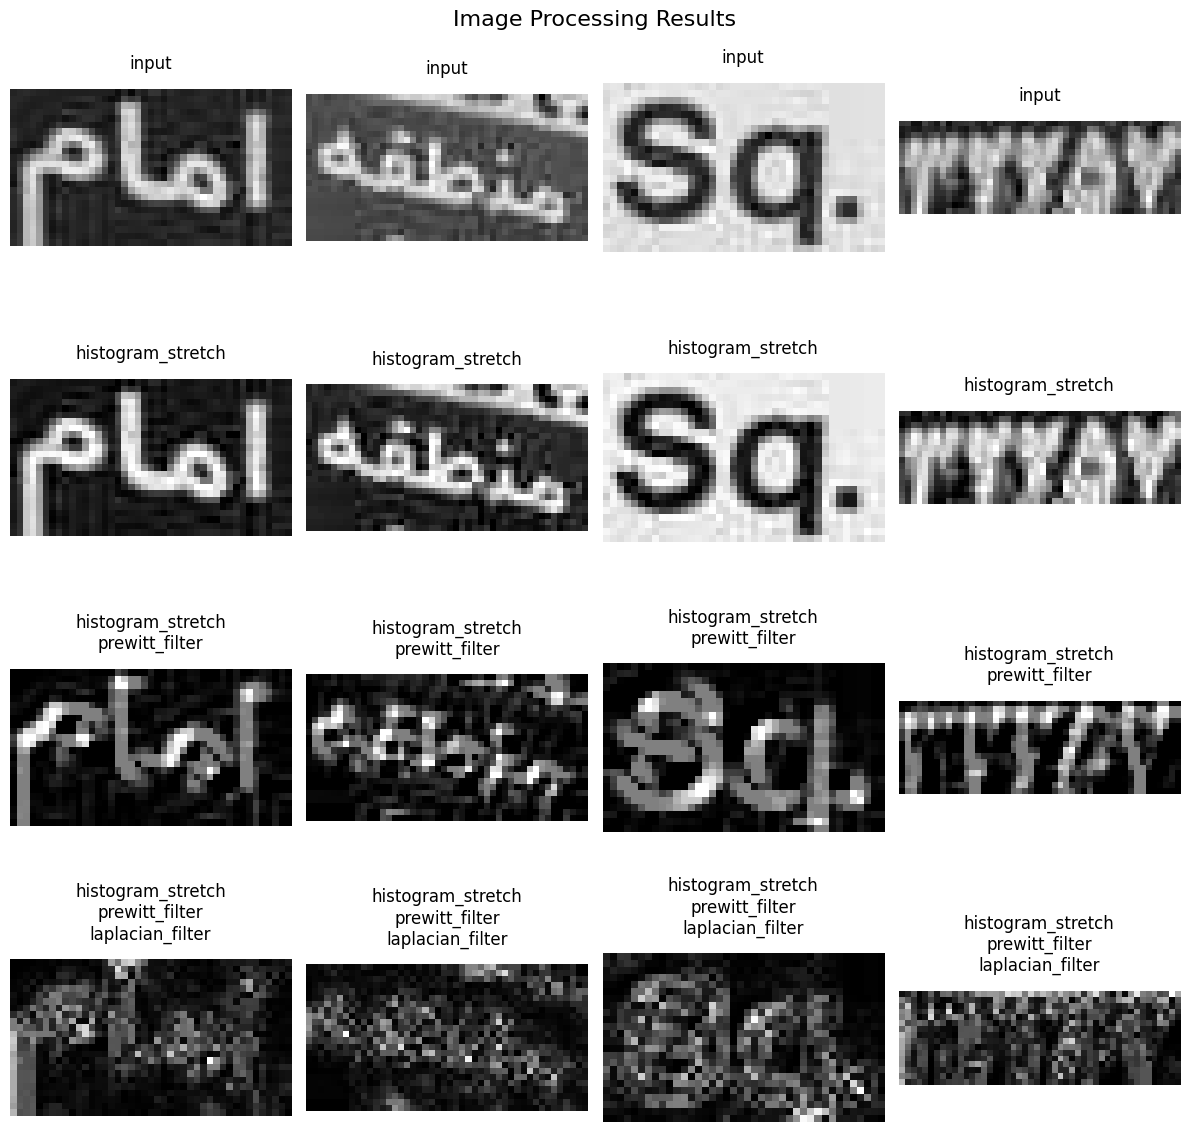

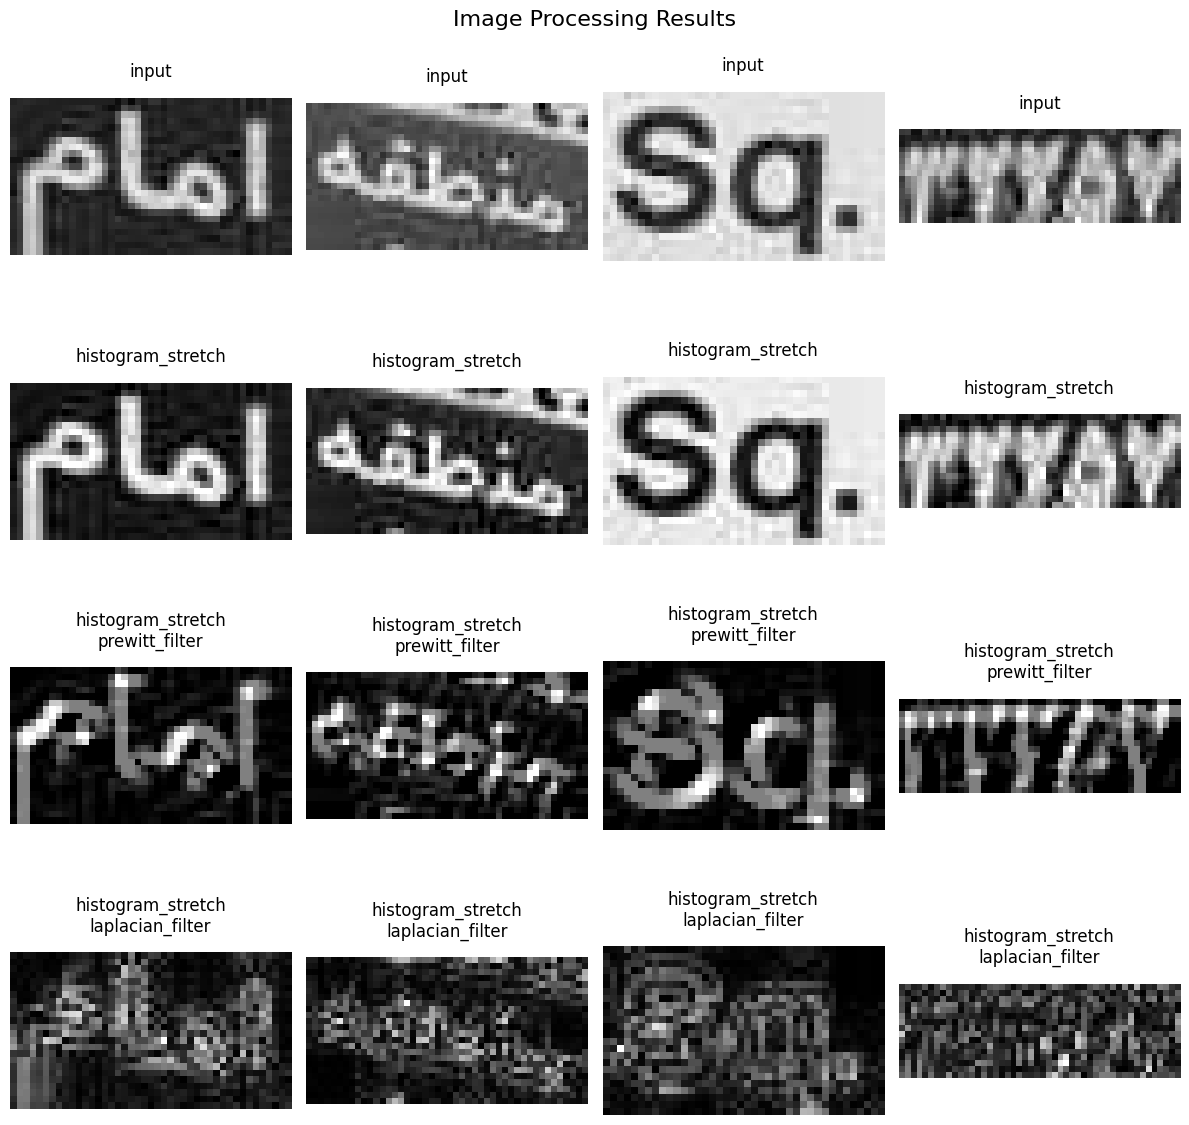

['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__r

In [1]:
from datasets import load_dataset
import numpy as np
from pixelist import ImagePipeline, ImageBatch, Filter, ProcessingMode
import cv2
from datasets import load_dataset
import numpy as np
from PIL import Image
import cv2
import pdb

def load_sample_images(num_samples: int = 5) -> list[np.ndarray]:
    """Load sample images from the road sign dataset."""
    dataset = load_dataset("aarmn/Persian_English_Roadsign_OCR_Dataset_Relabeled")
    
    # Get training split and sample randomly
    train_data = dataset['train']
    # Convert numpy.int32 to regular Python int
    indices = [int(i) for i in np.random.choice(len(train_data), num_samples, replace=False)]
    
    # Convert images to numpy arrays
    images = []
    for idx in indices:
        # Get PIL Image from dataset
        img: Image.Image = train_data[idx]['image']
        # Convert PIL to numpy array
        img_array = np.array(img)
        # Convert to grayscale if colored (RGB to GRAY)
        if len(img_array.shape) == 3:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        images.append(img_array)
    
    return images

def laplacian_filter(image: np.ndarray) -> np.ndarray:
    """Apply Laplacian filter for edge detection using manual kernel convolution."""
    # Laplacian kernel (8-connectivity) with reduced center weight
    kernel = np.array([
        [0.125,  0.125, 0.125],
        [0.125,    -1, 0.125],
        [0.125,  0.125, 0.125]
    ])
    
    # Apply convolution
    result = cv2.filter2D(image, cv2.CV_32F, kernel)
    
    # Convert to absolute values and normalize with better scaling
    result = np.absolute(result)
    result = result / np.max(result) if np.max(result) > 0 else result
    normalized = np.uint8(255 * result)
    
    return normalized

def prewitt_filter(image: np.ndarray) -> np.ndarray:
    """Apply Prewitt filter for edge detection."""
    kernel_x = np.array([
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1]
    ])
    kernel_y = np.array([
        [-1, -1, -1],
        [0, 0, 0],
        [1, 1, 1]
    ])
    
    grad_x = cv2.filter2D(image, -1, kernel_x)
    grad_y = cv2.filter2D(image, -1, kernel_y)
    
    return cv2.addWeighted(np.absolute(grad_x), 0.5, 
                          np.absolute(grad_y), 0.5, 0)

def histogram_stretch(image: np.ndarray) -> np.ndarray:
    """Apply histogram stretching."""
    p2, p98 = np.percentile(image, (2, 98))
    return np.clip((image - p2) * (255.0 / (p98 - p2)), 0, 255).astype(np.uint8)

def main():
    # Load sample images
    print("Loading dataset samples...")
    images = load_sample_images(4)
    
    # Add parentheses to decorator calls
    histogram_stretch_filter = Filter.make(histogram_stretch)
    prewitt_filter_decorated = Filter.make(prewitt_filter)
    laplacian_filter_decorated = Filter.make(laplacian_filter)

    # Create sequential pipeline
    seq_pipeline = ImagePipeline([histogram_stretch_filter, prewitt_filter_decorated, laplacian_filter_decorated])
    seq_result = seq_pipeline.run(images=images, mode=ProcessingMode.WITH_INTERMEDIATE_SHOW_ALL)
    
    # Create parallel pipeline
    par_pipeline = ImagePipeline([histogram_stretch_filter, (prewitt_filter_decorated, laplacian_filter_decorated)])
    # pdb.set_trace()
    par_result = par_pipeline.run(images=images, mode=ProcessingMode.WITH_INTERMEDIATE_SHOW_ALL)
    
    print(dir(par_result))
    print(dir(seq_result))


main()
print("All tests completed successfully!")